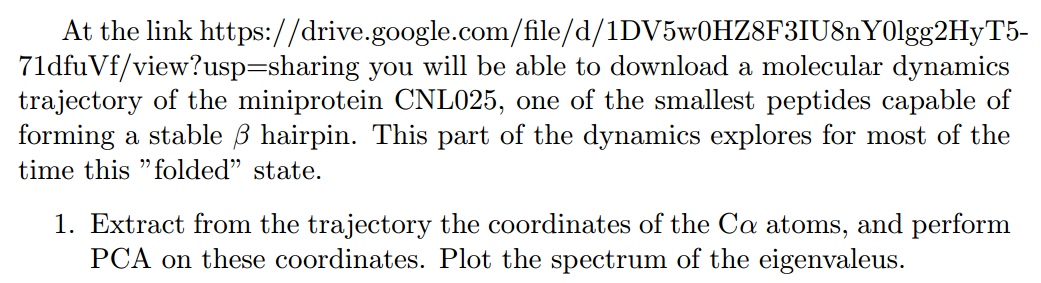

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

Read trajectory from file and center it

In [27]:
def readtraj(PDB):
    ''' Read the PDB file and return the coordinates of the CA atoms.
     The coordinates are returned as a numpy array of shape (D, N) where D is the number of CAs
     and N is the number of frames'''
    with open(PDB) as f:
        line = f.readline()
        ca_coord=[]
        while line:
            line = f.readline()
            while ("END" not in line) and line:
                if "CA" in line:
                    # Get the coordinates of the CA atoms
                    coord = line.split()[6:9]
                    ca_coord += coord
                line = f.readline()
    # Reshape the list into a numpy array
    return np.array(ca_coord).reshape((-1,30)).astype(float).transpose()


In [28]:
PDB = 'CLN025.pdb'
traj = readtraj(PDB)
# Centering: subtract to each row its average
traj -= np.mean(traj, axis=1)[:,None]
# Assert sum along row is zero
assert np.allclose(np.sum(traj, axis=1), np.zeros(traj.shape[0]))

# Number of frames
N = traj.shape[1]
# Number of CA atoms
D = traj.shape[0]

Compute Covariance matrix and plot its eigenvectors in decreasing order

In [29]:
# COVARIANCE MATRIX: Explicit definition
def CovMatrix(x):
    C = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            C[i,j] = np.dot(x[i,:],x[j,:])/N - np.average(x[i,:])*np.average(x[j,:]) # Second term needed only if data is not centered
    return C

# Vetorised version
def CovMatrixVectorised(x):
    # Centering: subtract average from each row
    x = x - np.average(x, axis=1)[:,None]
    # Assert sum of each row is zero
    assert np.allclose(np.sum(x, axis=1), np.zeros(D))
    
    return np.dot(x,x.T)/N

In [30]:
C = CovMatrixVectorised(traj[:,:])
# Compute eigenvalues and eigenvectors (sorted in ascending order)
eigenvalues , eigenvectors = np.linalg.eigh(C)

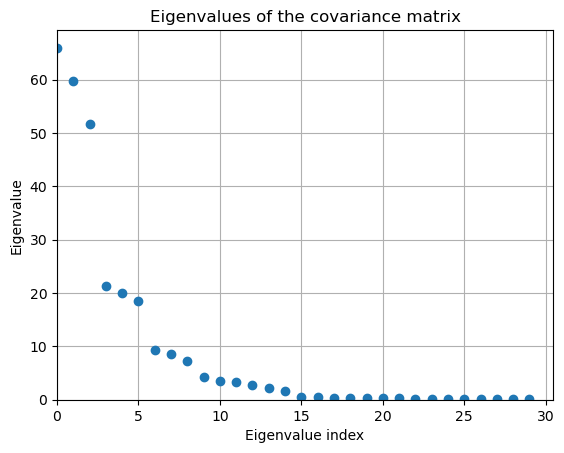

In [31]:
# Plot the eigenvalues in descending order
plt.plot(eigenvalues[::-1], linestyle = ' ', marker = 'o')
plt.xlim((0,None))
plt.ylim((0,None))
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the covariance matrix')
plt.grid()
#plt.yscale('log')
plt.show()

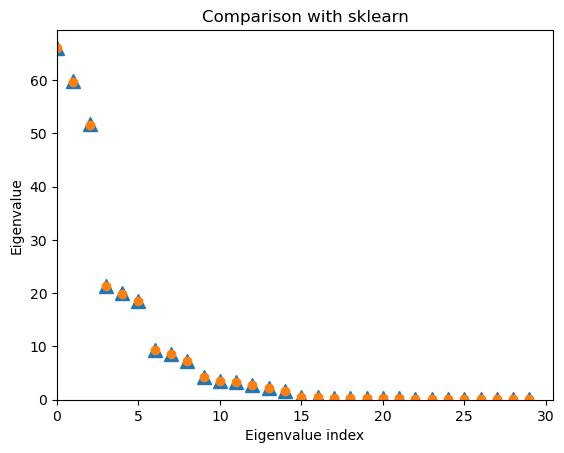

In [32]:
# Compare with PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(traj.transpose())
# Plot the eigenvalues in descending order
plt.plot(pca.explained_variance_, linestyle = ' ', marker = '^', markersize = 10, label = 'sklearn')
plt.plot(eigenvalues[::-1], linestyle = ' ', marker = 'o', label = 'own code')
plt.xlim((0,None))
plt.ylim((0,None))
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Comparison with sklearn')
plt.show()

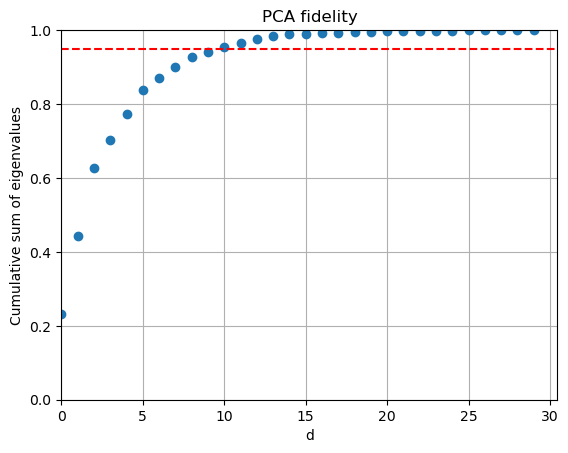

In [33]:
# Plot cumulative sum of eigenvalues normalized by the sum of all eigenvalues
plt.plot(np.cumsum(eigenvalues[::-1])/np.sum(eigenvalues), linestyle = ' ', marker = 'o')
plt.xlabel('d')
plt.ylabel('Cumulative sum of eigenvalues')
plt.ylim((0,1))
plt.xlim((0,None))
# Plot horizontal line corresponding to fideltiy of 95%
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('PCA fidelity')
plt.grid()
plt.show()

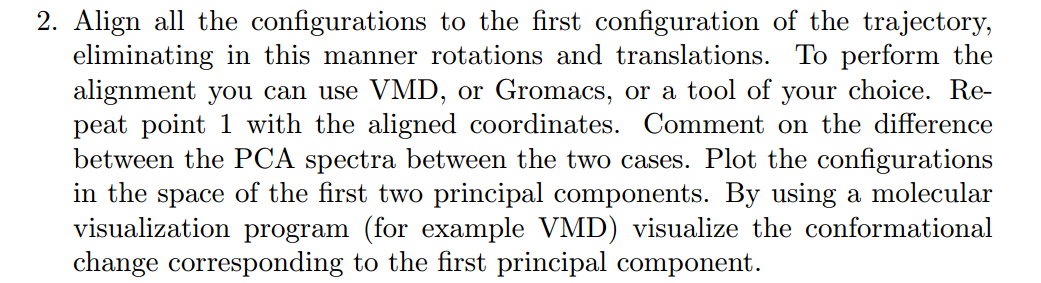

In [34]:
#PDB = 'aligned.pdb'
PDB = 'CLN025-aligned.pdb'
aligned_traj = readtraj(PDB)
# Centering: subtract to each row its average
aligned_traj -= np.mean(aligned_traj, axis=1)[:,None]
# Assert sum along row is zero
assert np.allclose(np.sum(aligned_traj, axis=1), np.zeros(aligned_traj.shape[0]))

C_aligned = CovMatrixVectorised(aligned_traj)
eigenvalues_aligned, eigenvectors_aligned = np.linalg.eigh(C_aligned)

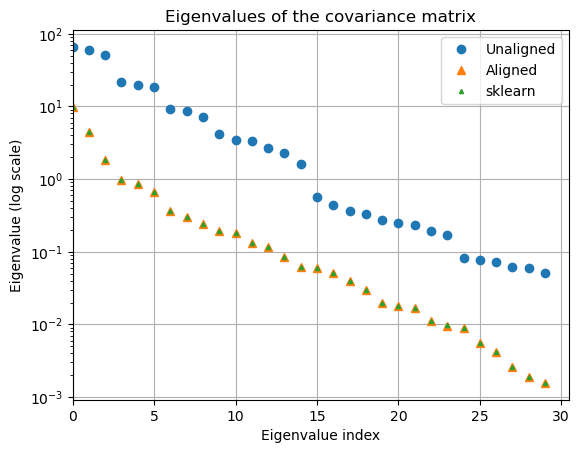

In [35]:
plt.plot(np.sort(eigenvalues)[::-1], linestyle = ' ', marker = 'o', label = 'Unaligned')
plt.plot(np.sort(eigenvalues_aligned)[::-1], linestyle = ' ', marker = '^', label = 'Aligned')
plt.xlim((0,None))
#plt.ylim((,None))
plt.yscale('log')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalues of the covariance matrix')

# Same with sklearn
pca = PCA(n_components=30)
pca.fit(aligned_traj.transpose())
# Plot the eigenvalues in descending order
plt.plot(pca.explained_variance_, linestyle = ' ', marker = '^', markersize = 3, label = 'sklearn')
plt.legend()
plt.grid()
plt.show()

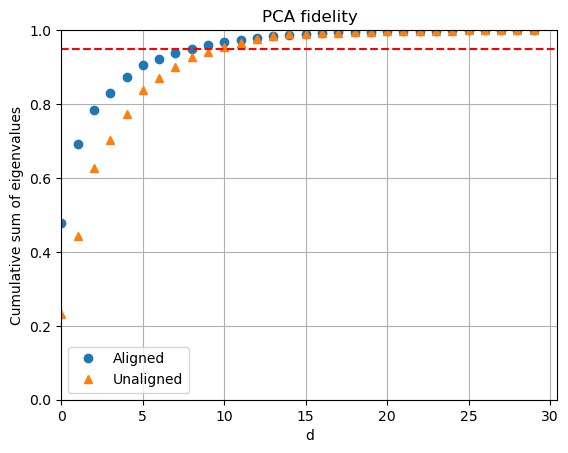

In [36]:
# Plot cumulative sum of eigenvalues normalized by the sum of all eigenvalues for the aligned and unaligned trajectories
plt.plot(np.cumsum(eigenvalues_aligned[::-1])/np.sum(eigenvalues_aligned), linestyle = ' ', marker = 'o', label = 'Aligned')
# Same for the unaligned trajectory
plt.plot(np.cumsum(eigenvalues[::-1])/np.sum(eigenvalues), linestyle = ' ', marker = '^', label = 'Unaligned')
# Same with sklearn
plt.xlabel('d')
plt.ylabel('Cumulative sum of eigenvalues')
plt.ylim((0,1))
plt.xlim((0,None))
# Plot horizontal line corresponding to fideltiy of 95%
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('PCA fidelity')
plt.legend()
plt.grid()
plt.show()

Plot in the space of the first two principal components and create file corresponding to the first principal component for visualization.

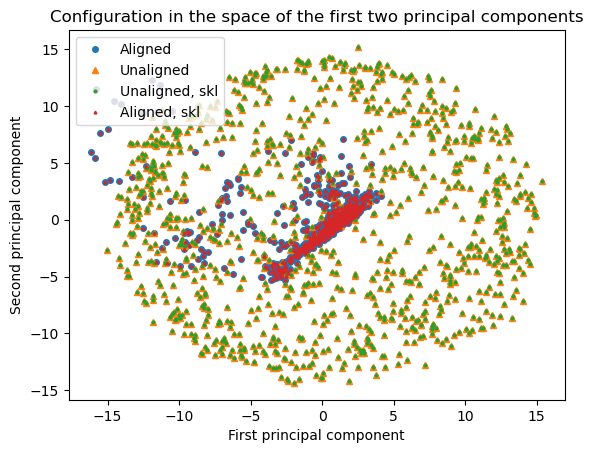

In [37]:
# Compute components of each column of traj in the last two eigenvectors
PC1 = np.dot(eigenvectors_aligned[:,-1], aligned_traj)
PC2 = np.dot(eigenvectors_aligned[:,-2], aligned_traj)
# Plot the configuration in the space of the first two principal components
plt.plot(PC1,PC2, linestyle = ' ', marker = 'o', markersize = 4, label = 'Aligned')

# Same with unaligned trajectory
PC1 = np.dot(eigenvectors[:,-1], traj)
PC2 = np.dot(eigenvectors[:,-2], traj)
plt.plot(PC1,PC2, linestyle = ' ', marker = '^', markersize = 4, label = 'Unaligned')

# Do same plot with sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(traj.transpose())
PC1 = pca.transform(traj.transpose())[:,0]
PC2 = pca.transform(traj.transpose())[:,1]
plt.plot(PC1,PC2, linestyle = ' ', marker = 'o', markersize = 2, label = 'Unaligned, skl')

pca = PCA(n_components=30)
pca.fit(aligned_traj.transpose())
PC1 = pca.transform(aligned_traj.transpose())[:,0]
PC2 = pca.transform(aligned_traj.transpose())[:,1]
plt.plot(-PC1,PC2, linestyle = ' ', marker = '^', markersize = 2, label = 'Aligned, skl')

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Configuration in the space of the first two principal components')
plt.legend()
plt.show()

In [38]:
# Crete file to visualize the first PC in VMD

def writeProjectedTrajectoryPDB(outputFileName, projectedTrajectory):
    '''Write a PDB file with the projected trajectory in the first PC.'''
    with open(outputFileName, 'w') as ofs:
        # Write header
        ofs.write("CRYST1   31.072   31.072   31.072  90.00  90.00  90.00 P 1           1\n")
        # For each frame of the trajectory
        for f in range(N):
            ofs.write("ATOM      5  CA  TYR X   1    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][:3]))
            ofs.write("ATOM     26  CA  TYR X   2    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][3:6]))
            ofs.write("ATOM     47  CA  ASP X   3    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][6:9]))
            ofs.write("ATOM     67  CA  PRO X   4    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][9:12]))
            ofs.write("ATOM     73  CA  GLU X   5    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][12:15]))
            ofs.write("ATOM     88  CA  THR X   6    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][15:18]))
            ofs.write("ATOM    102  CA  GLY X   7    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][18:21]))
            ofs.write("ATOM    109  CA  THR X   8    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][21:24]))
            ofs.write("ATOM    123  CA  TRP X   9    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][24:27]))
            ofs.write("ATOM    147  CA  TYR X  10    {:8.3f}{:8.3f}{:8.3f}  0.00  0.00    \n".format(*projectedTrajectory[f][27:30]))
            ofs.write("END\n")

# Trajectory of the first PC
trajectory_PC1 = np.zeros((N,D))
PC1 = np.dot(eigenvectors_aligned[:,-1], aligned_traj)
for t in range(N):
    trajectory_PC1[t,:] = PC1[t]*eigenvectors_aligned[:,-1]

# Add average coordinate vector to each row of trajectory_PC1
avg = np.mean(readtraj('CLN025.pdb'), axis=1)
trajectory_PC1 += avg

writeProjectedTrajectoryPDB('PC1.pdb', trajectory_PC1)

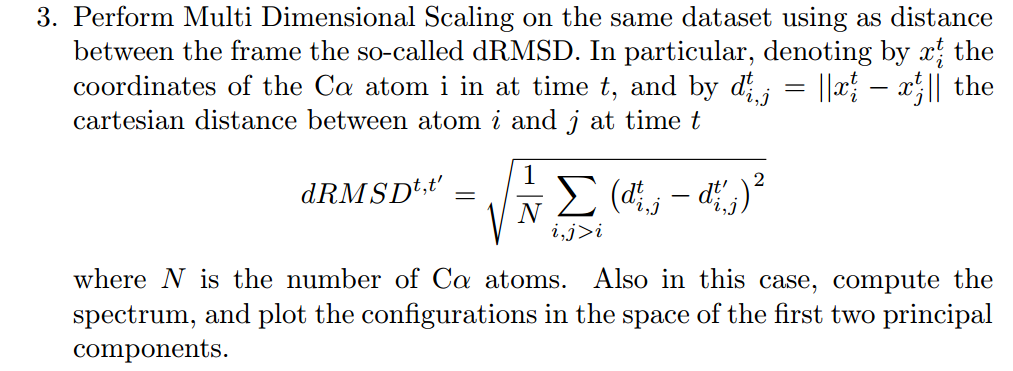

Compute distance and Grahm matrix

In [39]:
# distance matrix with dRMSD
import numba

@numba.jit(nopython=True, cache=True) # numba is used to speed up the computation for explicit loops
def dRMSDmatrix(trajectory):
    ''' Compute the dRMSD matrix of the trajectory.'''
    N = trajectory.shape[1]
    D = trajectory.shape[0]
    dRMSDmatrix = np.zeros((N,N))
    for t1 in range(N):

        for t2 in range(t1,N):
            sum = 0

            # Loop over all the atoms to compute the sum
            for i in range(D//3):
                for j in range(i+1, D//3):
                    # Get the coordinates of the two atoms at time t1
                    x_i_t1 = trajectory[3*i:3*(i+1),t1]
                    x_j_t1 = trajectory[3*j:3*(j+1),t1]
                    # Compute the distance
                    d_ij_t1 = np.linalg.norm(x_i_t1 - x_j_t1)

                    # Same for time t2
                    x_i_t2 = trajectory[3*i:3*(i+1),t2]
                    x_j_t2 = trajectory[3*j:3*(j+1),t2]
                    d_ij_t2 = np.linalg.norm(x_i_t2 - x_j_t2)

                    # Compute the squared difference
                    sum += (d_ij_t1 - d_ij_t2)**2

            dRMSDmatrix[t1,t2] = np.sqrt(sum/(D/3))
            dRMSDmatrix[t2,t1] = dRMSDmatrix[t1,t2]

    return dRMSDmatrix

def GrahmMatrix(distMatrix):
    ''' Compute the Grahm matrix from the distance matrix '''
    G = distMatrix +  np.average(distMatrix) - np.average(distMatrix, axis=0) - np.average(distMatrix, axis = 1).reshape((N,1))
    # Assert that the average of each row is zero
    assert np.allclose(np.average(G, axis=0), np.zeros(N))
    # Assert that the average of each column is zero
    assert np.allclose(np.average(G, axis=1), np.zeros(N))
    
    return -.5*G

In [40]:
# Choose whether to load the distance matrix from a file or compute it
load_dRMSD_file = True
# Load the distance matrix from a file if it exists
if os.path.exists('dist_matrix.txt') and load_dRMSD_file:
    dist = np.loadtxt('dist_matrix.txt')
else:
    dist = dRMSDmatrix(traj)
    np.savetxt('dist_matrix.txt', dist)

In [41]:
G = GrahmMatrix(dist)
G_eigenvalues , G_eigenvectors = np.linalg.eigh(G)

Plot eigenvalues

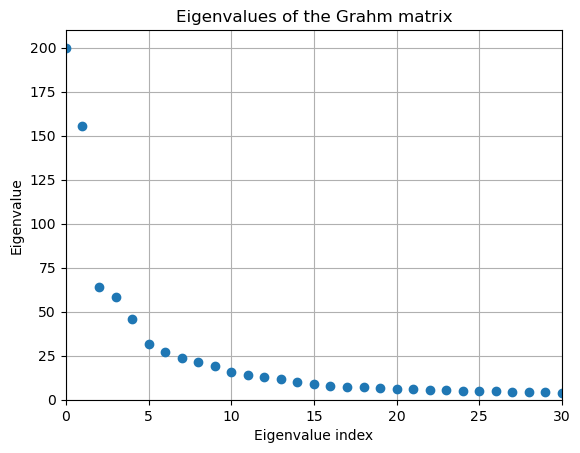

In [42]:
# Plot the eigenvalues of the Grahm matrix in decreasing order
plt.plot(G_eigenvalues[::-1], linestyle = ' ', marker = 'o')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Grahm matrix')
plt.xlim((0,D))
plt.ylim((0,None))
#plt.yscale('log')
plt.grid()
plt.show()



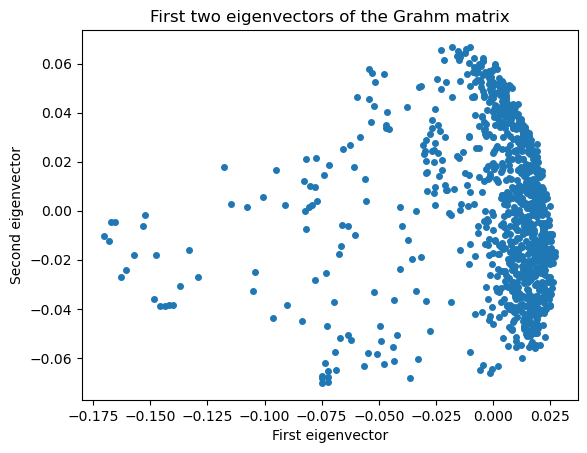

In [43]:
# Plot the first two eigenvectors
plt.plot(G_eigenvectors[:,-1], G_eigenvectors[:,-2], marker='o', linestyle = ' ', markersize = 4)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title('First two eigenvectors of the Grahm matrix')
plt.show()

![Alt text](../Screenshot%20from%202023-03-16%2011-21-59.png)

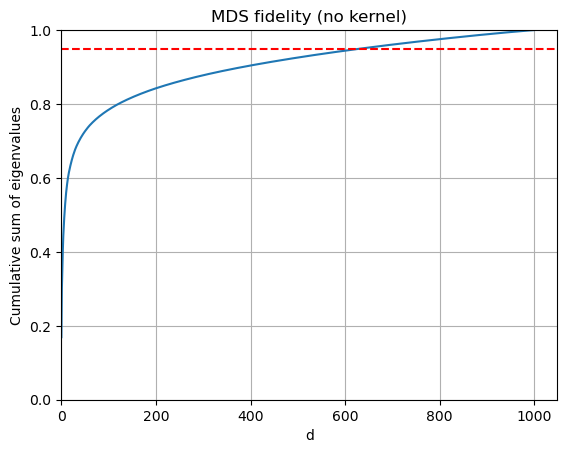

In [44]:
# Plot the cumulative sum of the eigenvalues of the Grahm matrix (normalised)
plt.plot(np.cumsum(G_eigenvalues[::-1])/np.sum(G_eigenvalues))
plt.xlabel('d')
plt.ylabel('Cumulative sum of eigenvalues')
plt.ylim((0,1))
plt.xlim((0,None))
# Plot horizontal line corresponding to fideltiy of 95%
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('MDS fidelity (no kernel)')
plt.grid()
plt.show()

In [45]:
# Gaussian kernel
def gaussianKernel(distMatrix, sigma):
    return 1-np.exp(-distMatrix**2/(2*sigma**2))
# tanh kernel
def tanhKernel(distMatrix, sigma = 1):
    return np.tanh(distMatrix/sigma)
    
# Compute the kernels
K_gaussian = gaussianKernel(dist, 1)
K_tanh = tanhKernel(dist)



[]

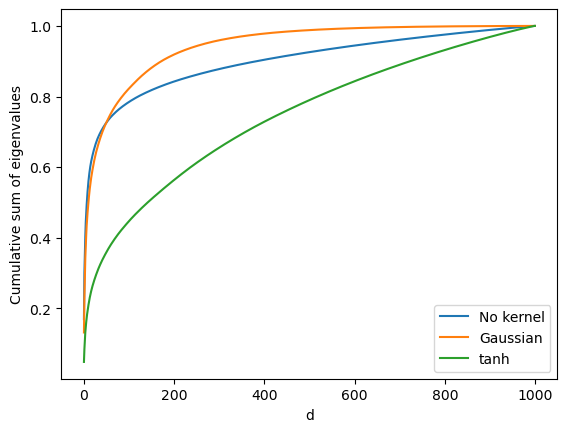

In [46]:
# No kernel
plt.plot(np.cumsum(G_eigenvalues[::-1])/np.sum(G_eigenvalues), label = 'No kernel')

for K, label in zip([K_gaussian, K_tanh], ['Gaussian', 'tanh']):
    # Compute Grahm matrix
    G = GrahmMatrix(K)
    # Compute the eigenvalues and eigenvectors
    G_eigenvalues , G_eigenvectors = np.linalg.eigh(G)
    # Plot the cumulative sum of the eigenvalues of the kernel matrix (normalised)
    plt.plot(np.cumsum(G_eigenvalues[::-1])/np.sum(G_eigenvalues), label = label)
plt.xlabel('d')
plt.ylabel('Cumulative sum of eigenvalues')
#plt.ylim((0,1))
plt.legend()
plt.plot()

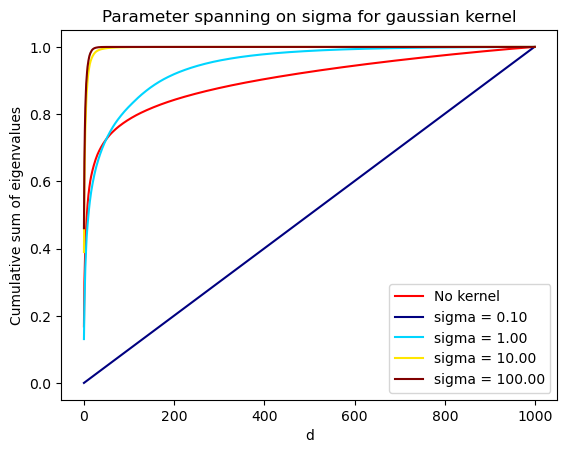

In [47]:
# Let's do a parameter spanning on sigma for gaussian kernel
sigma_span = np.logspace(-1, 2, 4)
# No kernel
G = GrahmMatrix(dist)
G_eigenvalues , G_eigenvectors = np.linalg.eigh(G)
plt.plot(np.cumsum(G_eigenvalues[::-1])/np.sum(G_eigenvalues), label = 'No kernel', color = 'red')
# Dictionary that maps sigma to its color
colors = {sigma:color  for sigma,color in zip ( sigma_span, plt.cm.jet(np.linspace(0,1,len(sigma_span))))}
# Plot eigenvalues for each sigma
for sigma in sigma_span:
    K = gaussianKernel(dist, sigma)
    G = GrahmMatrix(K)
    G_eigenvalues , G_eigenvectors = np.linalg.eigh(G)
    # Plot cumulative sum of eigenvalues
    plt.plot(np.cumsum(G_eigenvalues[::-1])/np.sum(G_eigenvalues), label = f'sigma = {sigma:.2f}', color = colors[sigma])
plt.xlabel('d')
plt.ylabel('Cumulative sum of eigenvalues')
plt.legend()
plt.title('Parameter spanning on sigma for gaussian kernel')
plt.show()


